# Facebook: Paid vs Unpaid Posts

### Introduction:
Facebook is one of the world's biggest social media platforms, and is a great place for businesses to reach consumers globally. Hence, we will be using two metrics for Facebook posts to answer: **can we use the amount of lifetime post total reach and lifetime people who have liked the page and engaged with the post to predict whether a future post is paid or unpaid?** We will be using a dataset with data from 2014 Facebook posts of a renowned cosmetic brand, including different post performance measures (e.g., number of likes) and post type (paid vs unpaid).


### Preliminary exploratory data analysis:
The dataset is downloadable in `csv` format, which we read into R using `read.delim`. We did not need to clean the data as it is already in tidy format.

The mapping for the numbers in the `Paid` column to post type is:

- 0 == Unpaid
- 1 == Paid

In [1]:
# load packages
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
set.seed(3060)
options(repr.plot.width = 8, repr.plot.height = 8)
options(repr.matrix.max.rows = 6)

# load data
facebook <- read.delim('data/dataset_Facebook.csv', sep = ';') %>%
    mutate(Paid = as_factor(Paid))
facebook

Page.total.likes,Type,Category,Post.Month,Post.Weekday,Post.Hour,Paid,Lifetime.Post.Total.Reach,Lifetime.Post.Total.Impressions,Lifetime.Engaged.Users,Lifetime.Post.Consumers,Lifetime.Post.Consumptions,Lifetime.Post.Impressions.by.people.who.have.liked.your.Page,Lifetime.Post.reach.by.people.who.like.your.Page,Lifetime.People.who.have.liked.your.Page.and.engaged.with.your.post,comment,like,share,Total.Interactions
<int>,<chr>,<int>,<int>,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
139441,Photo,2,12,4,3,0,2752,5091,178,109,159,3078,1640,119,4,79,17,100
139441,Status,2,12,3,10,0,10460,19057,1457,1361,1674,11710,6112,1108,5,130,29,164
139441,Photo,3,12,3,3,0,2413,4373,177,113,154,2812,1503,132,0,66,14,80
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
81370,Photo,1,1,5,2,0,3778,7216,625,572,795,4742,2388,363,4,93,18,115
81370,Photo,3,1,4,11,0,4156,7564,626,574,832,4534,2452,370,7,91,38,136
81370,Photo,2,1,4,4,NA,4188,7292,564,524,743,3861,2200,316,0,91,28,119


In [3]:
# split data into training and test set
facebook_split <- initial_split(facebook, prop = 0.75, strata = Paid) 
facebook_train <- training(facebook_split)   
facebook_test <- testing(facebook_split)

# summarize data
facebook_group <- facebook_train %>%
    group_by(Class = Paid) %>% 
    summarize(
        n = n(),
        mean_lifetime_post_total_reach = mean(Lifetime.Post.Total.Reach, na.rm = TRUE),
        mean_lifetime_people_liked_and_engaged = mean(Lifetime.People.who.have.liked.your.Page.and.engaged.with.your.post, na.RM = TRUE)
    )
facebook_group

`summarise()` ungrouping output (override with `.groups` argument)



Class,n,mean_lifetime_post_total_reach,mean_lifetime_people_liked_and_engaged
<fct>,<int>,<dbl>,<dbl>
0,270,12666.84,581.6741
1,105,19660.85,633.1619
NA,1,4188.00,316.0000


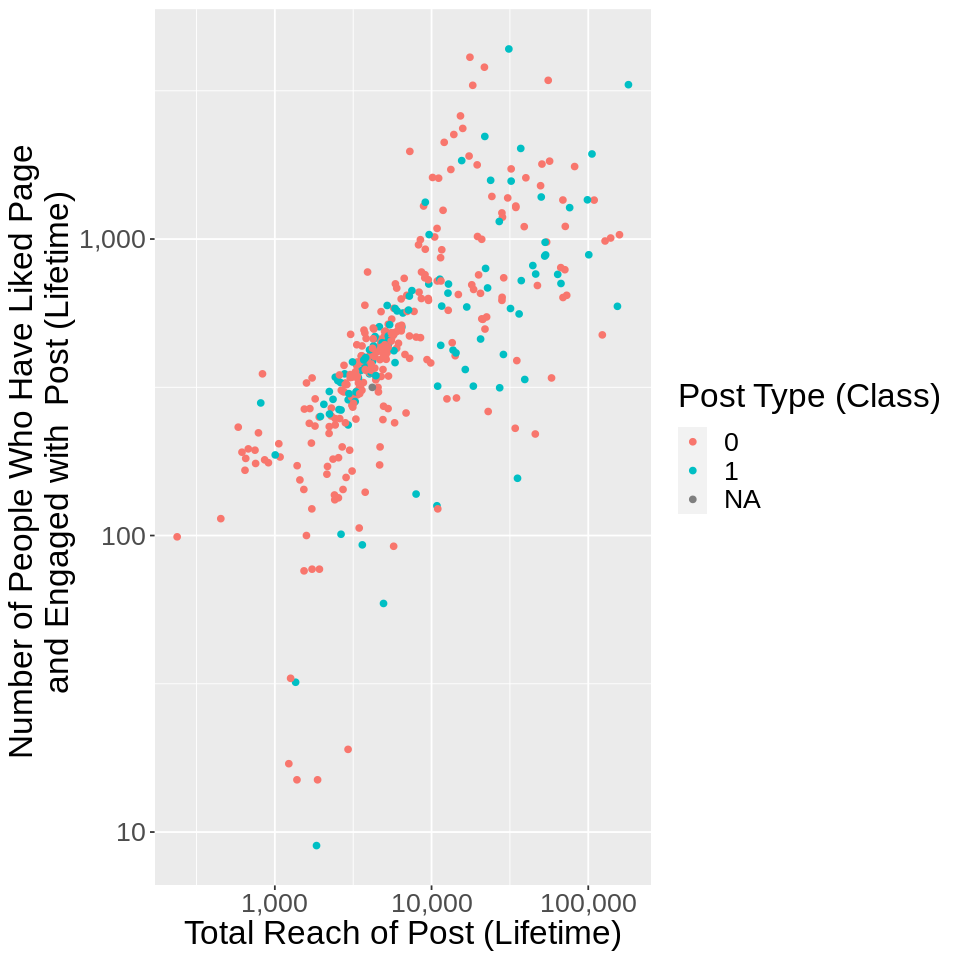

In [4]:
# create scatterplot
facebook_plot <- facebook_train %>% 
    ggplot(aes(x = Lifetime.Post.Total.Reach, y = Lifetime.People.who.have.liked.your.Page.and.engaged.with.your.post)) + 
            geom_point(aes(color = Paid)) +
            labs(x = 'Total Reach of Post (Lifetime)', y = 'Number of People Who Have Liked Page \n and Engaged with  Post (Lifetime)',
                 color = 'Post Type (Class)') +
            scale_x_log10(labels = scales::comma) +
            scale_y_log10(labels = scales::comma) +
            theme(text = element_text(size = 20))
facebook_plot

### Methods:
We will split the data into training and test sets, and build a K-nearest neighbour classifier to classify a post as paid or unpaid. 75% of the data will be used for training as the dataset has 500 rows, and 375 rows would be a good starting point. We will start with 5-fold cross-validation to choose the best K, but if accuracy is low, we will do 10-fold cross-validation. Finally, we will build the model on the optimal K value found and predict on the test set.

The columns we chose are total reach and total people who liked the page and engaged with the post. We can compare to determine if a relatively high total reach and more engagements on the post/page means that the post is paid or unpaid. A higher total reach means more users have seen the post whereas the total likes/engagement means users are also interested and invested in the content. Just because people see the post, does not mean they engage with it, which is why we chose both columns as our predictors.

As seen in the graph above, it is hard to visualize the points as they are very close together, so we will use prediction tables and confusion matrices to see the prediction accuracy.



### Expected outcomes and significance:
1. We expect to find that a relatively high total post reach and liked page/engaged post would mean that the post was paid.
2. The findings will likely be useful in designing marketing strategies to create more effective advertisements. Whether a business chooses to pay for a post, it would most likely have the amount of reach and engagement they want. Hence, the findings will help in advertising budgeting, especially for smaller businesses or start-ups that have less funds.
3. Does higher reach necessarily mean more people would be interested in the post regardless of the quality of the post? Should a company pay for a post only if it is guaranteed a certain cutoff of the amount of reach and people who have engaged with the post and liked the page? Is post reach or engagement with the post more significant to a business, or are there more variables to consider?
